# Initialize data

In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import librosa

bearingA = pd.read_excel("lozyska polaczone.xlsx",sheet_name='Łożysko_A').iloc[:,0:11].set_index('Time [s]')
bearingB = pd.read_excel("lozyska polaczone.xlsx",sheet_name='Łożysko_B').iloc[:,0:11].set_index('Time [s]')
bearingC = pd.read_excel("lozyska polaczone.xlsx",sheet_name='Łożysko_C').iloc[:,0:11].set_index('Time [s]')
bearingD = pd.read_excel("lozyska polaczone.xlsx",sheet_name='Łożysko_D').iloc[:,0:11].set_index('Time [s]')
bearingE = pd.read_excel("lozyska polaczone.xlsx",sheet_name='Łożysko_E').iloc[:,0:11].set_index('Time [s]')
bearingF = pd.read_excel("lozyska polaczone.xlsx",sheet_name='Łożysko_F').iloc[:,0:11].set_index('Time [s]')
bearingA, bearingF

(              A_P1       A_P2      A_P3      A_P4      A_P5      A_P6  \
 Time [s]                                                                
 0.20004  -0.519396  -0.857482 -3.493313 -4.067562 -4.106657  1.140219   
 0.20016   2.180017  -2.306301 -4.304790 -4.888874 -7.063714 -1.184193   
 0.20028   3.852659  -6.568164 -1.653053  2.848104 -8.963711  0.714433   
 0.20040  -1.038305  -9.880408 -3.249150  3.476073 -5.875597  0.999470   
 0.20052   1.854455  -6.060931 -6.129766 -2.603546 -1.718865  2.852845   
 ...            ...        ...       ...       ...       ...       ...   
 7.84668   5.163884  -3.730574 -3.578094  1.375764 -2.592770 -2.752423   
 7.84680   5.414033  -0.391876 -5.562483  3.157149 -0.717225 -0.955071   
 7.84692   2.640328 -11.806190 -4.744551  6.137130 -4.663985  0.952880   
 7.84704   3.450035 -13.799896 -1.833365  3.692787 -6.056617 -0.714057   
 7.84716   4.667976  -3.848692  0.140911  0.377114 -4.198191  1.467811   
 
               A_P7       A_P8      

In [31]:
bearingA_to_npArray = bearingA.to_numpy()
bearingA_to_npArray[:,1]

array([ -0.857482,  -2.306301,  -6.568164, ..., -11.80619 , -13.799896,
        -3.848692])

# Function creating features

Feature extraction is a crucial step in sound analysis. We use the librosa library to extract various features from audio recordings. In this case, we extract the following features:

**MFCCs (Mel-frequency cepstral coefficients)**: These coefficients represent the short-term power spectrum of sound, widely used in speech recognition and sound analysis. They provide a good representation of the spectral shape of the sound.

**Chroma STFT (Short-time Fourier Transform)**: It refers to the total energy in each of the twelve different chromatic bands, providing information about the tonality of the sound.

**Spectral Contrast**: Describes the difference in amplitude between peaks and valleys in the sound spectrum, indicating diversity in sound texture.

**Zero Crossing Rate**: It is the frequency at which the signal crosses zero. It's a simple indicator of sound characteristics that can be useful in distinguishing sounds of different textures.

## Function that creating features

In [32]:
def features_creator(segment, sample_rate, condition):
    nyquist_freq = sample_rate / 2
    fmin = nyquist_freq / 8  
    n_bands = 2 
    #new one
    #Time Domain Features
    rmse = librosa.feature.rms(y=segment) 
    zerocrossing_rate = librosa.feature.zero_crossing_rate(y=segment)
    tempo = librosa.feature.tempo(y=segment,sr=sample_rate)

    #Frequency Domain Features
    MFCC_feature = librosa.feature.mfcc(y=segment,sr=sample_rate)
    chroma = librosa.feature.chroma_stft(y=segment,sr=sample_rate)
    spectral_centroid = librosa.feature.spectral_centroid(y=segment,sr=sample_rate)
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=segment,sr=sample_rate)
    spectral_contrast = librosa.feature.spectral_contrast(y=segment, sr=sample_rate, fmin=fmin, n_bands=n_bands)
    spectral_rollfoff = librosa.feature.spectral_rolloff(y=segment,sr=sample_rate)

    #Time-Frequency Domain Features
    stft = librosa.feature.chroma_stft(y=segment,sr=sample_rate)
    melspectrogram = librosa.feature.melspectrogram(y=segment,sr=sample_rate)



    features = {        
        'condition': condition,
        'emse': np.mean(rmse,axis=1),
        'zerocrossing_rate': np.mean(zerocrossing_rate,axis=1),
        'tempo': np.mean(tempo),
        'melspectrogram': np.mean(melspectrogram,axis=1),
        'mfccs': np.mean(MFCC_feature,axis=1),
        'chroma': np.mean(chroma,axis=1),
        'spectral_centroid': np.mean(spectral_centroid,axis=1),
        'spectral_bandwidth': np.mean(spectral_bandwidth,axis=1),
        'spectral_contrast': np.mean(spectral_contrast, axis=1),
        'spectral_rollfoff': np.mean(spectral_rollfoff, axis=1),
        'stft': np.mean(stft, axis=1),
        }
    return features


## Function spliting data base to smaller part and using function `features_creator`

In [33]:
def data_spliter_with_feature(db, sample_rate, segment_length, num_segment, condition):
    all_features = []
    i=0
    for column in range(db.shape[1]):
        for iter_seg in range(num_segment):
            start = int(iter_seg * sample_rate * segment_length)
            end = start + int(sample_rate * segment_length)
            segment = db[start:end,column]
            
            if len(segment) == int(sample_rate * segment_length):
                features = features_creator(segment, sample_rate, condition)
            all_features.append(features)
            i += 1
    return pd.DataFrame(all_features)

## Usage of the function

In [34]:
sample_rate = 8335 
segment_length = 1  
num_segment = 10
bratingA_feature = data_spliter_with_feature(bearingA.to_numpy(),sample_rate, segment_length, num_segment, 'A')
bratingB_feature = data_spliter_with_feature(bearingB.to_numpy(),sample_rate, segment_length, num_segment, 'B')
bratingC_feature = data_spliter_with_feature(bearingC.to_numpy(),sample_rate, segment_length, num_segment, 'C')
bratingD_feature = data_spliter_with_feature(bearingD.to_numpy(),sample_rate, segment_length, num_segment, 'D')
bratingE_feature = data_spliter_with_feature(bearingE.to_numpy(),sample_rate, segment_length, num_segment, 'E')
bratingF_feature = data_spliter_with_feature(bearingF.to_numpy(),sample_rate, segment_length, num_segment, 'F')
segmented_df_features = pd.concat([bratingA_feature, bratingB_feature, bratingC_feature, bratingD_feature, bratingE_feature, bratingF_feature]).reset_index()

## Naming columns in DataFrame 

In [35]:
def expand_feature_column(series):
    feature_df = pd.DataFrame(series.tolist())
    return feature_df
new_columns = [segmented_df_features['condition']]
for column in segmented_df_features.columns:
    if column != 'condition':
        expanded_feature = expand_feature_column(segmented_df_features[column])
        expanded_feature.columns = [f"{column}_{i}" for i in range(expanded_feature.shape[1])]
        
        new_columns.append(expanded_feature)

numeric_df_features = pd.concat(new_columns, axis=1).drop('index_0', axis=1)


## Vizualization of features

We use the pairplot from the seaborn library to visualize relationships between different features and how they distribute across different sound conditions. This allows for an intuitive understanding of which features may be important in distinguishing between different states.

C:\Users\Admin\AppData\Local\Temp\ipykernel_18092\1228619534.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df['condition'] = numeric_df_features['condition']


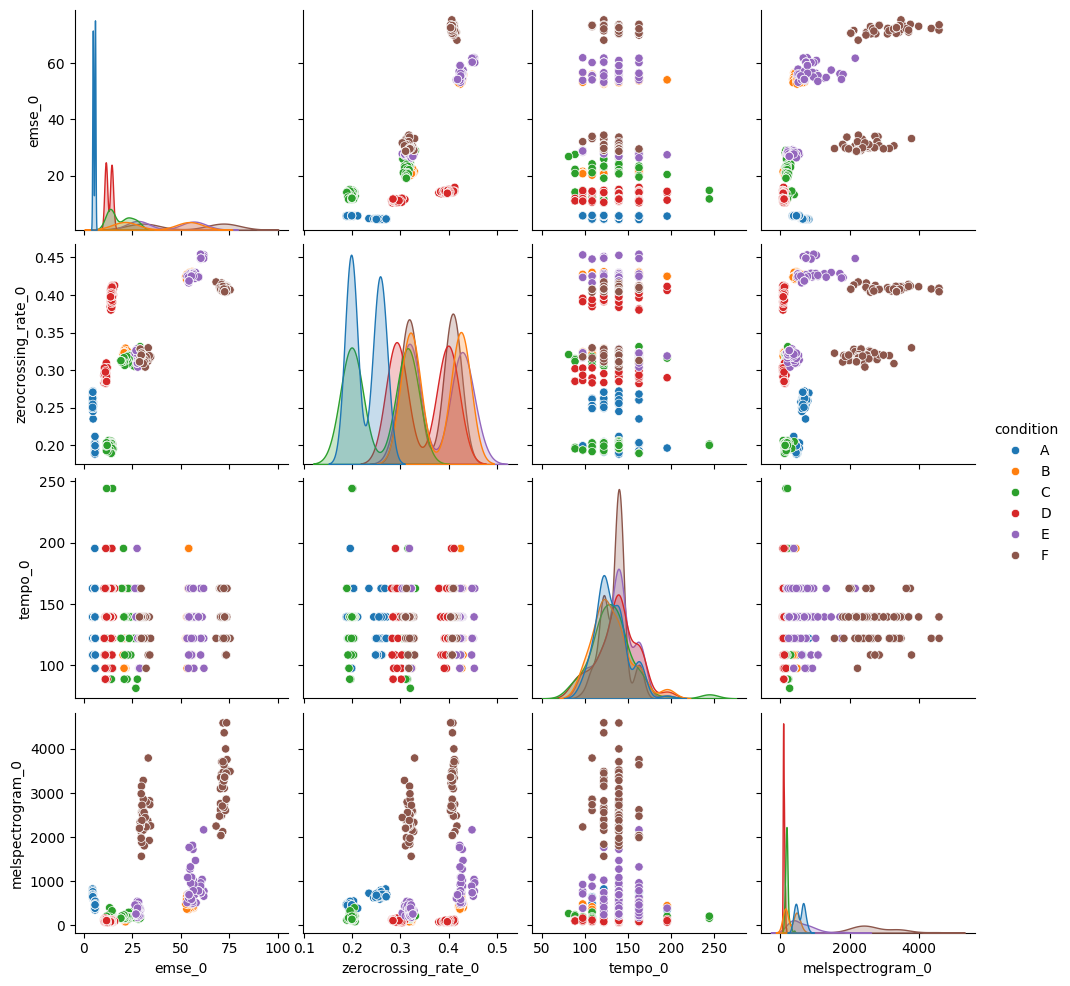

In [36]:
import seaborn as sns

# Wybór podzbioru cech do wizualizacji
selected_columns = numeric_df_features.columns[1:5]  # Przykładowy wybór pierwszych 5 kolumn cech
selected_df = numeric_df_features[selected_columns]
selected_df['condition'] = numeric_df_features['condition']

# Wyświetlenie sns.pairplot
sns.pairplot(selected_df, hue='condition')
plt.show()

## Correlation Analysis

Spearman correlation analysis is conducted to understand relationships between different features. Masking p-values above a predefined threshold allows focusing only on those correlations that are statistically significant.

C:\Users\Admin\AppData\Local\Temp\ipykernel_18092\3885838896.py:25: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mask = p_values.applymap(lambda x: x > p_value_threshold if pd.notnull(x) else False)


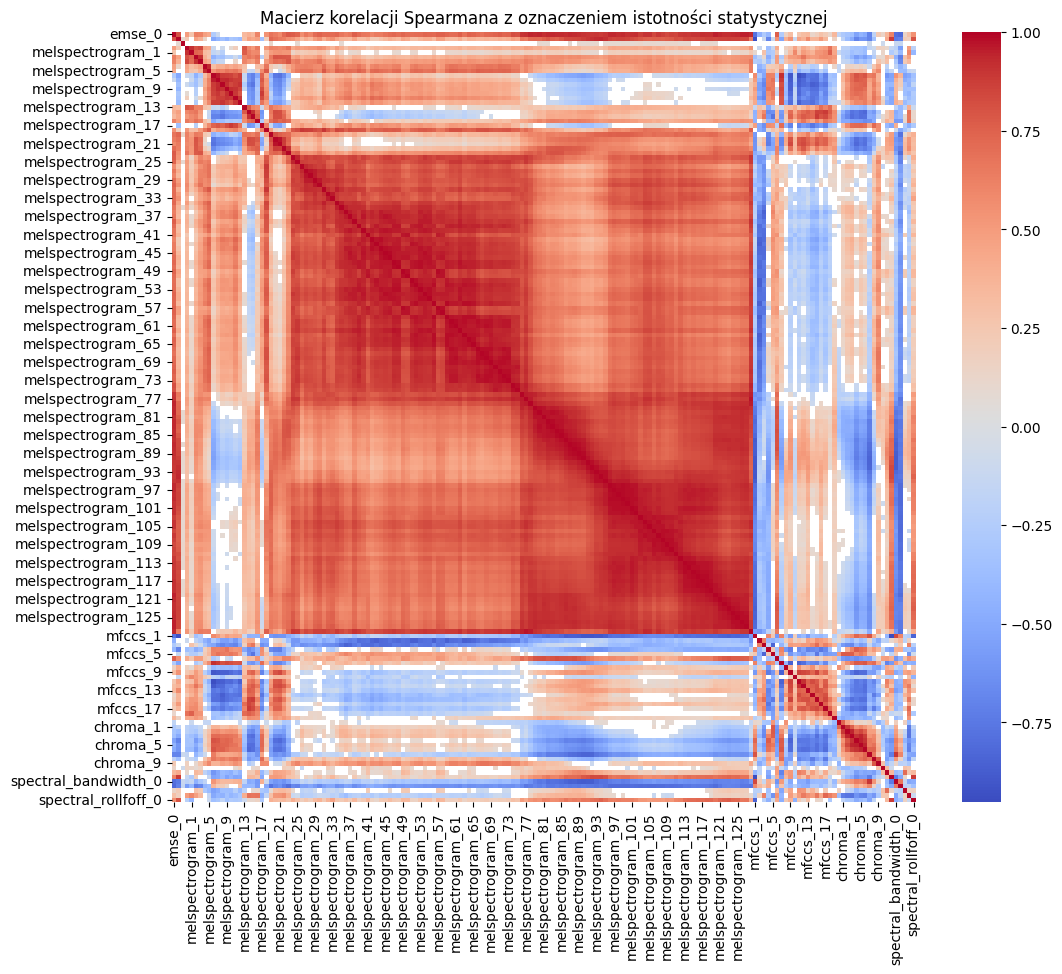

In [37]:
import scipy.stats

# Usunięcie kolumny 'condition' z DataFrame
numeric_features = numeric_df_features.drop('condition', axis=1)

# Obliczenie macierzy korelacji Spearmana
correlation_matrix = numeric_features.corr(method='spearman')

# Inicjalizacja DataFrame do przechowywania wartości p
p_values = pd.DataFrame(index=numeric_features.columns, columns=numeric_features.columns)

# Obliczanie wartości p dla każdej pary kolumn
for col1 in numeric_features.columns:
    for col2 in numeric_features.columns:
        if col1 != col2:
            _, p = scipy.stats.spearmanr(numeric_features[col1], numeric_features[col2])
            p_values.at[col1, col2] = p
        else:
            p_values.at[col1, col2] = np.nan

# Ustawienie progu istotności statystycznej
p_value_threshold = 0.05

# Tworzenie maski dla wartości p
mask = p_values.applymap(lambda x: x > p_value_threshold if pd.notnull(x) else False)

# Wyrysowanie macierzy korelacji z maską
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', mask=mask)
plt.title('Macierz korelacji Spearmana z oznaczeniem istotności statystycznej')
plt.show()